In [9]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [10]:
import numpy as np
import pandas as pd
import datetime as dt
from pandas.plotting import table
import os
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [11]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from dateutil.relativedelta import relativedelta
from datetime import datetime
import datetime as dt
import numpy as np
import pandas as pd
from pandas.plotting import table
import os
from scipy import stats
from datetime import timedelta

In [17]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [18]:
inspector = inspect(engine)

inspector.get_table_names()

['measurement', 'station']

In [19]:
# reflect an existing database into a new model
Base = automap_base()


# reflect the tables
Base.prepare(engine, reflect=True)

In [20]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [21]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
columns = inspector.get_columns('date')
for c in columns:
    print(c['name'], c["type"])

In [24]:
session.query(func.max(measurement.date)).all()

[('2017-08-23')]

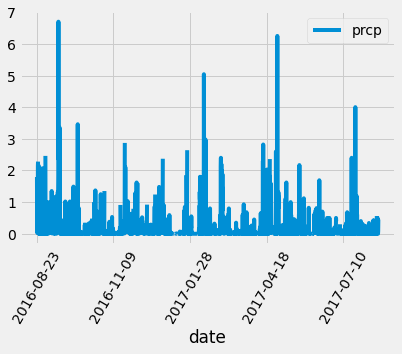

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

lastday = dt.date(2017, 8, 23)

oneyearbefore = lastday - timedelta(days=365)

oneyearbefore

# Perform a query to retrieve the data and precipitation scores

session.query(measurement.date, measurement.prcp).filter(measurement.date>=oneyearbefore).all()


# Save the query results as a Pandas DataFrame and set the index to the date column

datequery = pd.DataFrame(session.query(measurement.date, measurement.prcp).filter(measurement.date>=oneyearbefore).all())

datequery.set_index('date', inplace=True)

# Sort the dataframe by date

datequery.sort_values(by= 'date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data

datequery.plot(rot=60)

plt.savefig("Images/climate.png")

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data

datequery.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [27]:
# Design a query to calculate the total number stations in the dataset

session.query(func.count(station.name)).all()

[(9)]

In [28]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

session.query(measurement.station, func.count(measurement.date)).group_by(measurement.station).\
order_by(func.count(measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


mostactive=session.query(measurement.station).group_by(measurement.station).\
    order_by(func.count(measurement.date).desc()).first()

active_id = mostactive[0]


print(f"The most active id station is")

active_id

The most active id station is


'USC00519281'

In [30]:
active_station = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
filter(measurement.station == active_id)

active_station

for lowest_temp, highest_temp, avg_temp in active_station:
        print(f"The lowest temperature recorded at {active_id} was {lowest_temp}.")
        print(f"The highest temperature recorded at {active_id} was {highest_temp}.")
        print(f"The average temperature recorded at {active_id} was {avg_temp}.")

The lowest temperature recorded at USC00519281 was 54.0.
The highest temperature recorded at USC00519281 was 85.0.
The average temperature recorded at USC00519281 was 71.66378066378067.


In [31]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

lasttwelve = session.query(measurement.date).\
order_by(measurement.date.desc()).\
filter(measurement.station == active_id).first()

latest_date = lasttwelve[0]
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')
latest_date = latest_date.date()
date_year_ago = latest_date - relativedelta(years=1)

over_the_year = session.query(measurement.date, measurement.tobs).\
filter(measurement.station == active_id).\
filter(measurement.date >= date_year_ago).all()

yearcheck = pd.DataFrame(over_the_year, columns=['date', 'tobs'])

yearcheck.head()

,date,tobs
0,2016-08-18,80.0
1,2016-08-19,79.0
2,2016-08-20,81.0
3,2016-08-21,79.0
4,2016-08-22,78.0


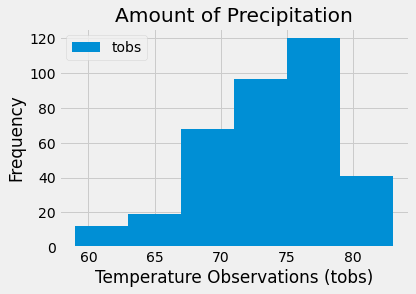

In [32]:
#create a hist plot
dataplot = pd.DataFrame(yearcheck, columns=['tobs'])
dataplot.plot.hist(bins=6)
plt.title(f"Amount of Precipitation")
plt.tight_layout()
plt.xlabel('Temperature Observations (tobs)')
plt.savefig("Images/Frequency.png")
plt.show()

# Close session

In [33]:
# Close Session
session.close()